# 03. Logistic Regression Classification
***

In this chapter we will use a first learning algorithm which is Logistic Regression. We are not going to recall all the math and logic behind this learning method. We are going to apply it to the training model in order to find the best predictive model, then test our model with the test dataset.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

***
## Load the training and testing datasets

In [3]:
# Loading the training dataset
data_train = pd.read_csv('./data/training_dataset.csv')
data_train.head()

,SibSp,Parch,Fare,Gender,Boarding_C,Boarding_Q,Boarding_S,Age,Pclass_1,Pclass_2,Pclass_3,Survived
0,0,0,13.0000,0,0,0,1,24.000000,0,1,0,0
1,1,0,16.1000,0,0,0,1,21.750000,0,0,1,1
2,0,0,30.6958,1,1,0,0,56.000000,1,0,0,0
3,1,1,24.1500,1,0,0,1,36.000000,0,0,1,0
4,0,0,7.2292,1,1,0,0,26.507589,0,0,1,0


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 12 columns):
SibSp         711 non-null int64
Parch         711 non-null int64
Fare          711 non-null float64
Gender        711 non-null int64
Boarding_C    711 non-null int64
Boarding_Q    711 non-null int64
Boarding_S    711 non-null int64
Age           711 non-null float64
Pclass_1      711 non-null int64
Pclass_2      711 non-null int64
Pclass_3      711 non-null int64
Survived      711 non-null int64
dtypes: float64(2), int64(10)
memory usage: 66.7 KB


In [5]:
# Loading the testing dataset
data_test = pd.read_csv('./data/testing_dataset.csv')

In [6]:
### Now getting X and Y for both the datasets
#
# Training dataset
X = data_train.drop(['Survived'], axis = 1)
Y = data_train['Survived']
#
# Testing dataset
X_test = data_test.drop(['Survived'], axis = 1)
Y_test = data_test['Survived']

***
## Logistic Regression on the Whole Training Dataset

In this first use of Logistic Regression using `sklearn`, we are going to use the full dataset to build the model.

In [7]:
# Building the model
lr = LogisticRegression()
lr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Making predictions
Y_hat = lr.predict(X)

In [9]:
print Y_hat[:20] # First 10 predictions...
print Y[:20].values # ... compared to real outputs

[1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0]
[0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0]


Which seems good. Now the scores of the model:

In [10]:
print "Accuracy on training data = %f" % lr.score(X, Y)
print "Accuracy on test data = %f" % lr.score(X_test, Y_test)

Accuracy on training data = 0.808720
Accuracy on test data = 0.792135


In [11]:
confusion_matrix(Y_test, lr.predict(X_test))

array([[91, 18],
       [19, 50]])

Here, the learning model from the training dataset has a good score but performs badly on the testing dataset. We can try a more robust methodology by performing a k-fold cross-validation on the whole dataset.

***
## Building k Logistic Regression models

The idea is to create _k_ different models (based on different datasets) and perform a voting on the final prediction. Here _k_ is unknown and should be selected by the algorithm to maximize good predictions. We are going to split the data into a test dataset, and a cross-validation dataset to find the ultimate _k_, and then, the k-different models.

To do so, let's build a class that have the same syntaxe of any `sklearn` methods.

In [13]:
# The k Logistic Regression models algorithm
class KLR(object):
    
    def __init__(self, min_k = 2, max_k = 30):
        self.min_k = min_k
        self.max_k = max_k
        self.optimum_k = 0
        self.models = []
        self.best_validation_score = 0
    
    def fit(self, X, Y):
        for k in np.arange(self.min_k, (self.max_k + 1)):
            current_validation_scores = []
            current_models = []
            
            # Collect validation score and model of each fold
            for train_indexes, validation_indexes in KFold(len(X), n_folds = k):
                model = LogisticRegression()
                model.fit(X[train_indexes], Y[train_indexes])
                
                current_validation_scores.append( model.score(X[validation_indexes], Y[validation_indexes]) )
                current_models.append( model )
            
            # Decide to update score, model and optimal-k if the validation score is improved
            if np.mean(current_validation_scores) > self.best_validation_score:
                self.best_validation_score = np.mean(current_validation_scores)
                self.models = current_models
                self.optimum_k = k
    
    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        
        sum_predictions = predictions[0]
        for i in np.arange(1, len(predictions)):
            sum_predictions = sum_predictions + predictions[i]

        return (sum_predictions >= (self.optimum_k / 2.)).astype(int)
        # This simulates the majority voting
    
    def score(self, X, Y):
        return np.mean([model.score(X, Y) for model in self.models])

In [14]:
# Build KLR model using the whole training dataset
# Remember that the KLR algorithm will internally perform Cross Validation to select the optimal k
klr = KLR()
klr.fit(X.values, Y.values)

In [15]:
# What is the optimal k?
klr.optimum_k

10

In [16]:
# First 20 predictions vs real values (0: died, 1: survived)
print klr.predict(X_test.values)[:20]
print Y_test.values[:20]

[0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0]
[0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0]


In [17]:
# What is the mean validation score for optimal k?
klr.best_validation_score

0.80604460093896724

In [18]:
# What is the training score of the model?
klr.score(X.values, Y.values)

0.80759493670886084

In [19]:
# What is the testing score of the model?
klr.score(X_test.values, Y_test.values)

0.78764044943820222

Unfortunately, averaging many logistic regression built with the same training dataset decreased our scoring for both training and testing datasets.

***
## Improving LR model using Grid Search Cross-Validation

We are trying in this section to improve the Logistic Regression model on the training dataset by introducing regularization and getting the best accuracy score using `sklearn` built-in `GridSearchCV` that will select the best LR estimator based on a list of possible parameters.

In [55]:
lrc = LogisticRegression()

gs = GridSearchCV(lrc, param_grid = { 'C': [(10 ** i) for i in range(-4, 5)], 'penalty': ['l1', 'l2'] }, cv = 5)
gs.fit(X, Y)

best_lrc = gs.best_estimator_

In [56]:
print "Using LR params %s produce the best model accuracy: %f" % (gs.best_params_, gs.best_score_)

Using LR params {'penalty': 'l2', 'C': 0.1} produce the best model accuracy: 0.805907


In [57]:
print "Accuracy on training data = %f" % best_lrc.score(X, Y)
print "Accuracy on test data = %f" % best_lrc.score(X_test, Y_test)

Accuracy on training data = 0.814346
Accuracy on test data = 0.808989


In [58]:
# The corresponding confusion matrix
print confusion_matrix(Y_test, best_lrc.predict(X_test))

[[97 12]
 [22 47]]


This model was built to maximize the predictions accuracy, by looking to the different combinations of the _penalty_ regularization and $C = \frac{1}{\alpha}$ pameters.

***
## ROC plot and analysis

Plotting the ROC curve and calculating AUC will help us to compare later different classification models.

In [76]:
fpr, tpr, thresholds = roc_curve(Y_test, best_lrc.predict_proba(X_test)[:,1])
print "ROC Area Under Curve (AUC) = %0.2f" % auc(fpr, tpr)

ROC Area Under Curve (AUC) = 0.83


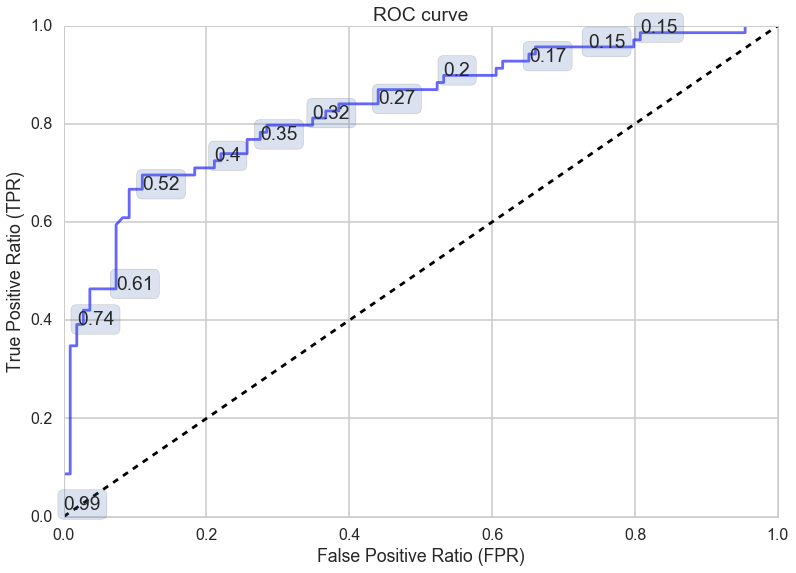

In [77]:
plt.plot(fpr, tpr, 'b', alpha = 0.6)
plt.plot([0, 1], [0, 1], 'k--')
for k in range(0, len(fpr), 5):
    plt.annotate(str(np.round(thresholds[k], 2)), (fpr[k], tpr[k]), **{'bbox': dict(boxstyle = 'round,pad = 0.3', alpha = 0.2)})
plt.xlabel('False Positive Ratio (FPR)')
plt.ylabel('True Positive Ratio (TPR)')
plt.title('ROC curve')
plt.show()

This confirms that the best prediction threshold to take in this study is at probability _0.5_. In addition, it shows that our model predictor performs better than just picking a prediction at random. This is because we are in the upper helf of the ROC curve.

***
## Conclusion

In this chapter, we tried to predict the passengers survival using Logistic Regression learning model.

Using the whole training dataset with default LR parameters produced a good model. We then tried a more complexe variation of LR by building many LR models and averaging their predictions (majority voting). Unfortunately, this increase in complexity led to worse predictions.

We finally tried to go back to the simple Logistic Regression model, but looked for the optimum one using different parameters values. Using built-in `sklearn` method `GridSearchCV`, we were able to improve our predictions and make a better accuracy score on the test data.

In the next few chapters, we will try other learning algorithms, starting with kNN classification.